In [1]:
# Ressources:
# https://spiyer99.github.io/Change-Audio-Pytorch/
# https://www.codespeedy.com/python-understanding-style-transfer-using-cnns/

In [2]:
# Imports
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
%tensorflow_version 2.x
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

import librosa
from librosa import display
import matplotlib.pyplot as plt
%matplotlib inline

from google.colab import files

In [3]:
# check for GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

In [4]:
# get Content-File
uploaded = files.upload()

CONTENT_FILENAME = list(uploaded.keys())[0]

Saving dancing_queen.mp3 to dancing_queen (3).mp3


In [5]:
# get Style-File
uploaded = files.upload()

STYLE_FILENAME = list(uploaded.keys())[0]

Saving musicfox_funky_stuff.mp3 to musicfox_funky_stuff.mp3


In [37]:
# Hyperparams
ITERATIONS = 50
CHANNELS = 3
#CONTENT_WEIGHT = 0.02
CONTENT_WEIGHT = 0.02
#STYLE_WEIGHT = 4.5
STYLE_WEIGHT = 4.5
#TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

N_FFT = 2048

N_SAMPLE = 2048*256

In [38]:
def read_audio_spectum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x[:N_SAMPLE], N_FFT)
    S = np.log1p(np.abs(S)) 
    return S, fs

In [39]:
a_content, fs = read_audio_spectum(CONTENT_FILENAME)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [40]:
a_style, fs = read_audio_spectum(STYLE_FILENAME)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [41]:
if a_content.shape[1] <= a_style.shape[1]:
  N_SAMPLES = a_content.shape[1]
else:
  N_SAMPLES = a_style.shape[1]

if a_content.shape[0] <= a_style.shape[0]:
  N_CHANNELS = a_content.shape[0]
else:
  N_CHANNELS = a_style.shape[0]

a_style = a_style[:N_CHANNELS, :N_SAMPLES]
a_content = a_content[:N_CHANNELS, :N_SAMPLES]

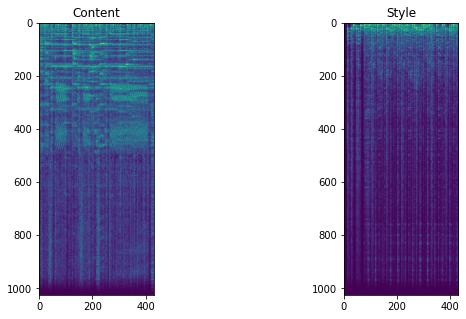

In [42]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content)
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style)
plt.show()

In [43]:
maxVal = a_content.max()
minVal = a_content.min()
print(maxVal, minVal)



5.563166 6.3758074e-07


In [44]:
a_style2 = cv2.cvtColor(a_style, cv2.COLOR_GRAY2BGR)
a_content2 = cv2.cvtColor(a_content, cv2.COLOR_GRAY2BGR)

In [45]:
a_style3 = np.interp(a_style2, (a_style2.min(), a_style2.max()), (0, 1))
a_content3 = np.interp(a_content2, (a_content2.min(), a_content2.max()), (0, 1))

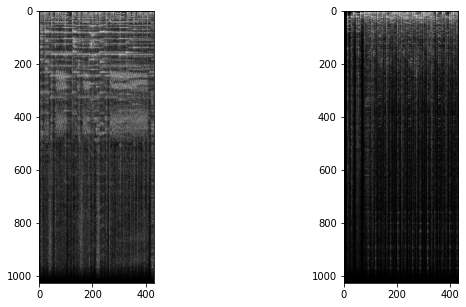

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(a_content3)
plt.subplot(1, 2, 2)
plt.imshow(a_style3)

In [47]:
input_image_array = np.asarray(a_content3, dtype="float32")
input_image_array = np.expand_dims(input_image_array, axis=0)

input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(a_style3, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)

style_image_array = style_image_array[:, :, :, ::-1]

input_image = backend.variable(input_image_array)
style_image = backend.variable(style_image_array)

IMAGE_HEIGHT = a_content2.shape[0]
IMAGE_WIDTH = a_content2.shape[1]

combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))

In [48]:
IMAGE_HEIGHT = a_content.shape[0]
IMAGE_WIDTH = a_content.shape[1]

In [49]:
input_tensor = backend.concatenate([input_image, style_image, combination_image], axis=0)

In [50]:
model = VGG16(input_tensor=input_tensor, include_top=False)

In [51]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layers = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = "block2_conv2"
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = backend.variable(0.)
loss = loss + CONTENT_WEIGHT * content_loss(content_image_features, combination_features)

In [52]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [53]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss = loss + (STYLE_WEIGHT / len(style_layers)) * style_loss

In [54]:
def total_variation_loss(x):
    a = backend.square(x[:, :-1, :-1, :] - x[:, 1:, :-1, :])
    b = backend.square(x[:, :-1, :-1, :] - x[:, :-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

In [55]:
loss = loss + TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)

In [56]:
outputs = [loss]
outputs = outputs + backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

In [57]:
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

In [58]:
with tf.device('/device:GPU:0'):
    for i in range(ITERATIONS):
        x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
        print("Iteration %d completed with loss %d" % (i, loss))

Iteration 0 completed with loss 134674896
Iteration 1 completed with loss 5383551
Iteration 2 completed with loss 1294659
Iteration 3 completed with loss 653688
Iteration 4 completed with loss 399772
Iteration 5 completed with loss 268775
Iteration 6 completed with loss 183565
Iteration 7 completed with loss 126747
Iteration 8 completed with loss 96134
Iteration 9 completed with loss 80277
Iteration 10 completed with loss 67598
Iteration 11 completed with loss 58145
Iteration 12 completed with loss 50921
Iteration 13 completed with loss 44299
Iteration 14 completed with loss 38673
Iteration 15 completed with loss 33835
Iteration 16 completed with loss 29302
Iteration 17 completed with loss 25738
Iteration 18 completed with loss 22742
Iteration 19 completed with loss 20159
Iteration 20 completed with loss 18200
Iteration 21 completed with loss 16472
Iteration 22 completed with loss 15139
Iteration 23 completed with loss 14069
Iteration 24 completed with loss 13180
Iteration 25 completed

In [59]:
result = np.float32(x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)))
result = np.expm1(result)
result = np.clip(result, 0, maxVal)
result = np.interp(result, (result.min(), result.max()), (0, 1))

result = np.float32(result)

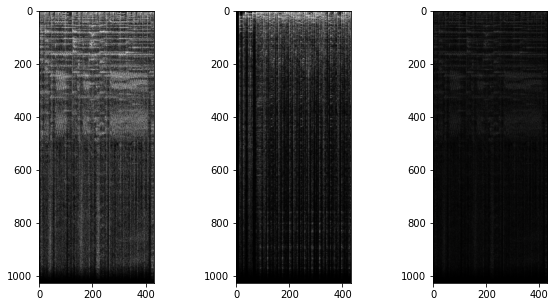

In [60]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(a_content3)
plt.subplot(1, 3, 2)
plt.imshow(a_style3)
plt.subplot(1, 3, 3)
plt.imshow(result)

In [61]:
result2 = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)

In [62]:
xd = result2[:, :, 2];

#xd = np.expm1(xd)

xd = np.interp(xd, (xd.min(), xd.max()), (minVal, maxVal))

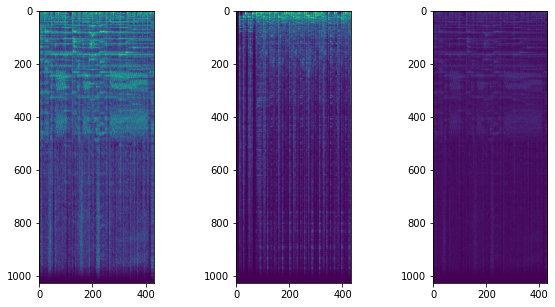

In [63]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(a_content)
plt.subplot(1, 3, 2)
plt.imshow(a_style)
plt.subplot(1, 3, 3)
plt.imshow(xd)

In [64]:
a = np.zeros_like(xd)
a = np.exp(xd) - 1
#This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(1000):
    S = a * np.exp(1j*p)
    xout = librosa.istft(S)
    p = np.angle(librosa.stft(xout, N_FFT))

In [65]:
OUTPUT_FILENAME = 'output'+ '_content:' + CONTENT_FILENAME[:-4] + '_style:' + STYLE_FILENAME[:-4] + '_iterations:' + str(ITERATIONS) + '_cweight:' + str(CONTENT_WEIGHT) + '_sweight' + str(STYLE_WEIGHT) + '.wav'

print(OUTPUT_FILENAME)

output_content:dancing_queen_style:musicfox_funky_stuff_iterations:50_cweight:0.02_sweight4.5.wav


In [66]:
import soundfile as sf
sf.write(OUTPUT_FILENAME, xout, fs)

files.download(OUTPUT_FILENAME)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>